1. Consider the two variables: TOTAL_REVENUE and TOTAL_EXPENDITURE. Do these variables have outlier values?

2. If you detect outliers in the TOTAL_REVENUE and TOTAL_EXPENDITURE variables, apply the techniques you learned in this checkpoint to eliminate them and validate that there's no outlier values after you handled them.

3. Create another variable by subtracting the original TOTAL_EXPENDITURE from TOTAL_REVENUE (before you eliminated the outliers). You can think of it as a kind of budget deficit in education. Do you find any outlier values in this new variable? If so, eliminate them using the technique you think most suitable.

4. Now create another variable by subtracting the TOTAL_EXPENDITURE from TOTAL_REVENUE. This time, use the outlier eliminated versions of TOTAL_EXPENDITURE from TOTAL_REVENUE. In this newly created variable, can you find any outliers? If so, eliminate them.

5. Compare some basic descriptive statistics of the budget variables you end up with in the 3rd and the 4th questions. Do you see any differences?

6. If our variable of interest is the budget deficit variable, which method do you think is the appropriate in dealing with the outliers in this variable: the method in the 3rd question or the one in the 4th question?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'useducation'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

education_df = pd.read_sql_query('select * from useducation',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

We fill in the missing values using interpolation since our data is a time series data:

In [3]:
fill_list = ["ENROLL", "TOTAL_REVENUE", "FEDERAL_REVENUE",
             "STATE_REVENUE", "LOCAL_REVENUE", "TOTAL_EXPENDITURE",
             "INSTRUCTION_EXPENDITURE", "SUPPORT_SERVICES_EXPENDITURE",
             "OTHER_EXPENDITURE", "CAPITAL_OUTLAY_EXPENDITURE", "GRADES_PK_G",
             "GRADES_KG_G", "GRADES_4_G", "GRADES_8_G", "GRADES_12_G", "GRADES_1_8_G",
             "GRADES_9_12_G", "GRADES_ALL_G"]

states = education_df["STATE"].unique()

for state in states:
    education_df.loc[education_df["STATE"] == state, fill_list] = education_df.loc[education_df["STATE"] == state, fill_list].interpolate()

# we drop the null values after interpolation
education_df.dropna(inplace=True)

## 1. Consider the two variables: TOTAL_REVENUE and TOTAL_EXPENDITURE. Do these variables have outlier values?

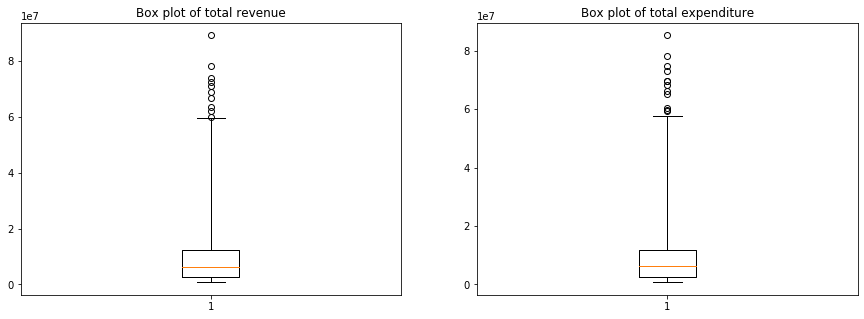

In [4]:
plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.boxplot(education_df["TOTAL_REVENUE"], whis = 5)
plt.title("Box plot of total revenue")

plt.subplot(1,2,2)
plt.boxplot(education_df["TOTAL_EXPENDITURE"], whis = 5)
plt.title("Box plot of total expenditure")
plt.show()

As we see from the boxplots, both variables have outlier values.

## 2. If you detect outliers in the TOTAL_REVENUE and TOTAL_EXPENDITURE variables, apply the techniques you learned in this checkpoint to eliminate them and validate that there's no outlier values afterwards you handled them.

We'll use winsorization to eliminate the outliers and create two new variables called winsorized_revenue and winsorized_expenditure for the winsorized variants.

In [5]:
from scipy.stats.mstats import winsorize

winsorized_revenue = winsorize(education_df["TOTAL_REVENUE"], (0, 0.05))

winsorized_expenditure = winsorize(education_df["TOTAL_EXPENDITURE"], (0, 0.05))

Now let's check whether the outliers are eliminated or not:

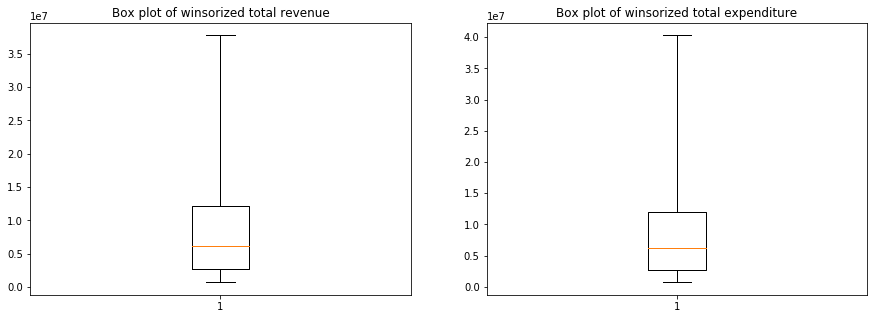

In [6]:
plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.boxplot(winsorized_revenue, whis = 5)
plt.title("Box plot of winsorized total revenue")

plt.subplot(1,2,2)
plt.boxplot(winsorized_expenditure, whis = 5)
plt.title("Box plot of winsorized total expenditure")
plt.show()

It seems that all the outliers are eliminated after the winsorization.

## 3. Create another variable by subtracting the original TOTAL_EXPENDITURE from TOTAL_REVENUE (before you eliminated the outliers). You can think of it as a kind of budget deficit in education. Do you find any outlier values in this new variable? If so, eliminate them using the technique you think most suitable.

In [7]:
budget_deficit = education_df.TOTAL_REVENUE - education_df.TOTAL_EXPENDITURE

Text(0.5, 1.0, 'Box plot of budget deficit')

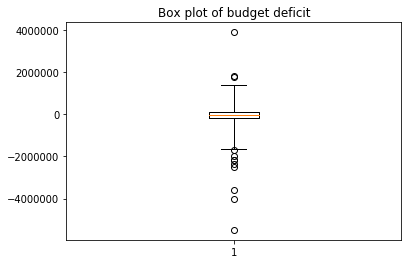

In [8]:
plt.boxplot(budget_deficit, whis = 5)
plt.title("Box plot of budget deficit")

It seems that we have outliers on both tailes. So, let's winsorize it:

In [9]:
winsorized_budget = winsorize(budget_deficit, (0.05, 0.05))

Text(0.5, 1.0, 'Box plot of budget deficit')

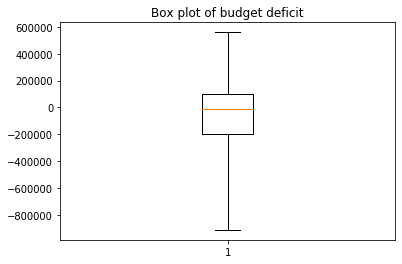

In [10]:
plt.boxplot(winsorized_budget, whis = 5)
plt.title("Box plot of budget deficit")

It seems that the outliers are eliminated.

## 4. Now create another variable by subtracting the TOTAL_EXPENDITURE from TOTAL_REVENUE. But this time, use the outlier eliminated versions of TOTAL_EXPENDITURE from TOTAL_REVENUE. In this newly created variable, can you find any outliers? If so, eliminate them.

In [11]:
budget_deficit2 = winsorized_revenue - winsorized_expenditure

Text(0.5, 1.0, 'Box plot of budget deficit 2')

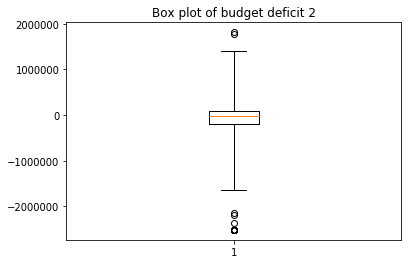

In [12]:
plt.boxplot(budget_deficit2, whis = 5)
plt.title("Box plot of budget deficit 2")

It seems we have outliers, so let's eliminate them:

In [13]:
winsorized_budget2 = winsorize(budget_deficit2, (0.05, 0.05))

Text(0.5, 1.0, 'Box plot of budget deficit 2')

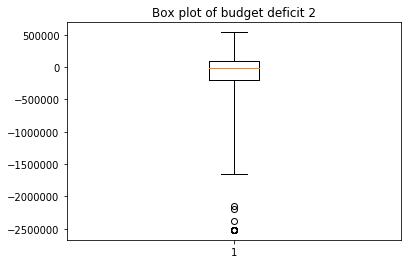

In [14]:
plt.boxplot(winsorized_budget2, whis = 5)
plt.title("Box plot of budget deficit 2")

We successfully eliminated many of the outliers. If we increase the lower bound of the winsorization, the remaining few ones also would be eliminated but for consistency with the analysis above, we keep winsorizing the values using 5% as the threshold percentiles at both ends.

## 5. Compare some basic statistics of the budget variables you end up with in the third and the fourth questions. Do you see any differences?

In [15]:
pd.DataFrame({"original_budget": budget_deficit, "winsorized_budget1": winsorized_budget,
              "winsorized_budget2": winsorized_budget2}).describe()

,original_budget,winsorized_budget1,winsorized_budget2
count,4.660000e+02,466.000000,4.660000e+02
mean,-8.094882e+04,-58733.012876,-1.720532e+05
std,6.144222e+05,341300.816505,6.509561e+05
min,-5.487742e+06,-913765.000000,-2.518429e+06
25%,-1.965748e+05,-196574.750000,-2.047750e+05
50%,-8.872500e+03,-8872.500000,-1.282350e+04
75%,1.013948e+05,101394.750000,9.826300e+04
max,3.897129e+06,560511.000000,5.400550e+05


For almost all critical statistics, the two variables differ substantially. For example:

1. The mean of the first variant is -61210.33 whereas the mean of the second variant is -173636.

2. The median of the first variant is -8872.5 whereas the median of the second variant is -12823.5.

3. The maximum of the first variant is 560511 whereas the maximum of the second variant is 540055.

The differences imply that chosing the outlier elimination strategy is very critical as it substantially affects the statistics of the variables!

## 6. If our variable of interest is the budget deficit variable, which method do you think is the most appropriate one in dealing with the outliers in this variable. The method in the third question or the one in the fourth question?

Sometimes, differencing may help us to eliminate the outliers. So, it's better to first create a variable from the originals and then to apply outlier elimination techniques next. Hence, the approach in the third question is more desirable in most of the cases.